In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import argparse
import skimage.transform
from tensorboardX import SummaryWriter
import random
import os
import os.path
import matplotlib.image as mpimg
from PIL import Image
import import_ipynb
from MonodepthModel import *
import scipy.misc
import scipy.io as sio
import cv2
from IPython.display import clear_output
from flow_warp.Optical_Flow_Warping_Tensorflow.flownet2_pytorch.networks.submodules import *
from flow_warp.Optical_Flow_Warping_Tensorflow.flownet2_pytorch.networks.resample2d_package.modules.resample2d import Resample2d
os.environ['TF_CPP_MIN_LOG_LEVEL']='1'

torch.cuda.set_device(0)

importing Jupyter notebook from MonodepthModel.ipynb


In [2]:
def get_args():
    parser = argparse.ArgumentParser(description='Monodepth PyTorch implementation.')
    
    parser.add_argument('--mode',                      type=str,   help='train or test', default='train')
    parser.add_argument('--model_name',                type=str,   help='model name', default='monodepth')
    parser.add_argument('--encoder',                   type=str,   help='type of encoder, vgg or resnet50', default='vgg')
    parser.add_argument('--dataset',                   type=str,   help='dataset to train on, kitti, or cityscapes', default='kitti')
    parser.add_argument('--data_path',                 type=str,   help='path to the data', required=True)
    parser.add_argument('--filenames_file',            type=str,   help='path to the filenames text file', required=True)
    parser.add_argument('--input_height',              type=int,   help='input height', default=256)
    parser.add_argument('--input_width',               type=int,   help='input width', default=512)
    parser.add_argument('--batch_size',                type=int,   help='batch size', default=8)
    parser.add_argument('--num_epochs',                type=int,   help='number of epochs', default=50)
    parser.add_argument('--learning_rate',             type=float, help='initial learning rate', default=1e-4)
    parser.add_argument('--lr_loss_weight',            type=float, help='left-right consistency weight', default=1.0)
    parser.add_argument('--alpha_image_loss',          type=float, help='weight between SSIM and L1 in the image loss', default=0.85)
    parser.add_argument('--disp_gradient_loss_weight', type=float, help='disparity smoothness weigth', default=0.1)
    parser.add_argument('--do_stereo',                             help='if set, will train the stereo model', action='store_true')
    parser.add_argument('--wrap_mode',                 type=str,   help='bilinear sampler wrap mode, edge or border', default='border')
    parser.add_argument('--use_deconv',                            help='if set, will use transposed convolutions', action='store_true')
    parser.add_argument('--num_gpus',                  type=int,   help='number of GPUs to use for training', default=1)
    parser.add_argument('--num_threads',               type=int,   help='number of threads to use for data loading', default=8)
    parser.add_argument('--output_directory',          type=str,   help='output directory for test disparities, if empty outputs to checkpoint folder', default='')
    parser.add_argument('--log_directory',             type=str,   help='directory to save checkpoints and summaries', default='')
    parser.add_argument('--checkpoint_path',           type=str,   help='path to a specific checkpoint to load', default='')
    parser.add_argument('--retrain',                               help='if used with checkpoint_path, will restart training from step zero', action='store_true')
    parser.add_argument('--full_summary',                          help='if set, will keep more data for each summary. Warning: the file can become very large', action='store_true')
    
    args = parser.parse_args()
    return args


In [3]:
#args = get_args()
#net = MonodepthNet().cuda()
#net = torch.load("/home/hylai/monodepth/model_city2kitti")
net = torch.load("/eva_data/hylai_model/kitti_flow_supervised_syn_44/model_epoch35")
optimizer = optim.Adam(net.parameters(), lr=1e-4)
params = list(net.parameters())
name = list(net.named_parameters())

In [4]:
def get_data(path = '/eva_data/hylai_model/my/output/folder/'):
    #path2 = '/eva_data/hylai_model/dataset/kitti2/'
    file_path_train = '/home/hylai/monodepth/utils/filenames/kitti_train_files.txt'
    file_path_test = '/home/hylai/monodepth/utils/filenames/eigen_test_files.txt'
    #file_path_flow_train = '/home/hylai/monodepth/utils/filenames/kitti_total_flow_train_files.txt'
    f_train = open(file_path_train)
    f_test = open(file_path_test)
    #f_flow_train = open(file_path_flow_train)
    left_image_train = list()
    right_image_train = list()
    left_image_test = list()
    right_image_test = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        left_image_train.append(path+line.split()[0])
        right_image_train.append(path+line.split()[1])
    for line in f_test:
        num_test += 1
        left_image_test.append(path+line.split()[0])
        right_image_test.append(path+line.split()[1])
        
    return left_image_train, right_image_train, left_image_test, right_image_test, num_train, num_test

In [5]:
def get_cs_data(path_right = '/eva_data/hylai_model/dataset/cityscape/rightImg8bit/train_extra/'):
    path_left = '/eva_data/hylai_model/dataset/cityscape/leftImg8bit/train_extra/'
    file_path_train = '/home/hylai/monodepth/utils/filenames/cityscapes_train_files.txt'
    file_path_test = '/home/hylai/monodepth/utils/filenames/cityscapes_test_files.txt'
    f_train = open(file_path_train)
    f_test = open(file_path_test)
    left_image_train = list()
    right_image_train = list()
    left_image_test = list()
    right_image_test = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        left_image_train.append(path_left+line.split()[0])
        right_image_train.append(path_right+line.split()[1])
    for line in f_test:
        num_test += 1
        left_image_test.append(path_left+line.split()[0])
        right_image_test.append(path_right+line.split()[1])
        
    return left_image_train, right_image_train, left_image_test, right_image_test, num_train, num_test

In [68]:
def get_flow_data(path = '/eva_data/hylai_model/dataset/kitti/'):
    path2 = '/eva_data/hylai_model/dataset/kitti/'
    file_path_train = '/home/hylai/monodepth/utils/filenames/kitti_total_flow_train_files.txt'
    file_path_test = '/home/hylai/monodepth/utils/filenames/kitti_flow_val_files_50.txt'
    f_train = open(file_path_train)
    f_test = open(file_path_test)
    former_image_train = list()
    latter_image_train = list()
    flow_train = list()
    former_image_test = list()
    latter_image_test = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        former_image_train.append(path+line.split()[0])
        latter_image_train.append(path+line.split()[1])
        #flow_train.append(path+line.split()[2])
    for line in f_test:
        num_test += 1
        former_image_test.append(path+line.split()[0])
        latter_image_test.append(path+line.split()[1])
        flow_train.append(path+line.split()[2])
        
    return former_image_train, latter_image_train, former_image_test, latter_image_test, flow_train

In [8]:
def get_play_data(path = '/eva_data/hylai_model/dataset/play_for_benchmark/'):
    #path2 = '/eva_data/hylai_model/dataset/kitti/'
    file_path_train = '/eva_data/hylai_model/dataset/play_for_benchmark/flow_train.txt'
    #file_path_test = '/home/hylai/monodepth/utils/filenames/kitti_flow_test_files.txt'
    f_train = open(file_path_train)
    former_image_train = list()
    latter_image_train = list()
    flow_train = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        former_image_train.append(path+line.split()[0])
        latter_image_train.append(path+line.split()[1])
        flow_train.append(path+line.split()[2])
    """
    for line in f_test:
        num_test += 1
        former_image_test.append(path+line.split()[0])
        latter_image_test.append(path+line.split()[1])
    """
        
    return former_image_train, latter_image_train, flow_train
"""
import os, os.path
from random import randint
a = [0]
for i in range(1, 78):
    path = '/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/'+"%03d"%i
    f = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    path = '/eva_data/hylai_model/dataset/play_for_benchmark/train/img/'+"%03d"%i
    i = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    a.append(i)
print(a)

count = 0
wtf = 0
wtf2 = 0
while 1:
    random_dir = randint(1, 77)
    random_file = randint(1, a[random_dir]-1)
    if not os.path.isfile('/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.mat'):
        wtf += 1
        continue
    print(random_dir, random_file)
    k = sio.loadmat('/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.mat')
    print(random_dir, random_file)
    if 'u' not in k or 'v' not in k:
        wtf2 += 1
        print("???")
        continue
    with open('/eva_data/hylai_model/dataset/play_for_benchmark/flow_train.txt', 'a') as f:
        f.write('train/img/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.png ')
        f.write('train/img/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%(random_file+1)+'.png ')
        f.write('train/flow/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.mat\n')
        count += 1
    clear_output()
    if count == 1081:
        break
print(count, wtf, wtf2)
"""

'\nimport os, os.path\nfrom random import randint\na = [0]\nfor i in range(1, 78):\n    path = \'/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/\'+"%03d"%i\n    f = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])\n    path = \'/eva_data/hylai_model/dataset/play_for_benchmark/train/img/\'+"%03d"%i\n    i = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])\n    a.append(i)\nprint(a)\n\ncount = 0\nwtf = 0\nwtf2 = 0\nwhile 1:\n    random_dir = randint(1, 77)\n    random_file = randint(1, a[random_dir]-1)\n    if not os.path.isfile(\'/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/\'+"%03d"%random_dir+\'/\'+"%03d"%random_dir+\'_\'+"%05d"%random_file+\'.mat\'):\n        wtf += 1\n        continue\n    print(random_dir, random_file)\n    k = sio.loadmat(\'/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/\'+"%03d"%random_dir+\'/\'+"%03d"%random_dir+\'_\'+"%05d"%random_file+\'.mat\')\n   

In [9]:
def get_transform():
    return transforms.Compose([
        transforms.Scale([512, 256]),
        transforms.ToTensor()
    ])

In [263]:
class myImageFolder(data.Dataset):
    def __init__(self, left, right, training, flow = None):
        self.right = right
        self.left = left
        self.training = training
        self.flow = flow
        
    def __getitem__(self, index):
        left = self.left[index]
        right = self.right[index]
        left_image = Image.open(left).convert('RGB')
        right_image = Image.open(right).convert('RGB')
        
        if self.flow is not None:
            flow = self.flow[index]
            flow_image = Image.open(flow).convert('RGB')
            #d = sio.loadmat(flow)
            #flow_image = np.concatenate((np.expand_dims(d['u'], 2), np.expand_dims(d['v'], 2)), axis = 2)
            #where_are_nan = np.isnan(flow_image)
            #flow_image[where_are_nan] = 0
        
        #augmentation
        if self.training:
            
            #randomly flip
            if random.uniform(0, 1) > 0.5 and self.flow is None:
                left_image = left_image.transpose(Image.FLIP_LEFT_RIGHT)
                right_image = right_image.transpose(Image.FLIP_LEFT_RIGHT)
                if self.flow is not None:
                    flow_image = flow_image.transpose(Image.FLIP_LEFT_RIGHT)
                
            #randomly shift gamma
            if random.uniform(0, 1) > 0.5:
                gamma = random.uniform(0.8, 1.2)
                left_image = Image.fromarray(np.clip((np.array(left_image) ** gamma), 0, 255).astype('uint8'), 'RGB')
                right_image = Image.fromarray(np.clip((np.array(right_image) ** gamma), 0, 255).astype('uint8'), 'RGB')
            
            #randomly shift brightness
            if random.uniform(0, 1) > 0.5:
                brightness = random.uniform(0.5, 2.0)
                left_image = Image.fromarray(np.clip((np.array(left_image) * brightness), 0, 255).astype('uint8'), 'RGB')
                right_image = Image.fromarray(np.clip((np.array(right_image) * brightness), 0, 255).astype('uint8'), 'RGB')
            
            #randomly shift color
            if random.uniform(0, 1) > 0.5:
                colors = [random.uniform(0.8, 1.2) for i in range(3)]
                shape = np.array(left_image).shape
                white = np.ones((shape[0], shape[1]))
                color_image = np.stack([white * colors[i] for i in range(3)], axis=2)
                left_image = Image.fromarray(np.clip((np.array(left_image) * color_image), 0, 255).astype('uint8'), 'RGB')
                right_image = Image.fromarray(np.clip((np.array(right_image) * color_image), 0, 255).astype('uint8'), 'RGB')
                
        
        #transforms
        process = get_transform()
        left_image = process(left_image)
        right_image = process(right_image)
        
        if self.flow is not None:
            h, w, _ = np.asarray(flow_image).shape
            #flow_image = process(flow_image)
            flow_image = transforms.Scale([512, 256])(flow_image)
            #flow_image[0,:,:] = - (flow_image[0,:,:] - 0.5) * flow_image.shape[2]
            #flow_image[1,:,:] = (flow_image[1,:,:] - 0.5) * flow_image.shape[1]
            flow_image = np.asarray(flow_image)
            a = (flow_image[:,:,0] / 256 - 0.5) * flow_image.shape[1]
            b = (flow_image[:,:,1] / 256 - 0.5) * flow_image.shape[0]
            a = np.expand_dims(a, 0)
            b = np.expand_dims(b, 0)
            c = np.concatenate((a,b), 0)
            flow = torch.from_numpy(c)
            #flow_image[0,:,:] = flow_image[0,:,:] * flow_image.shape[2] / 1920
            #flow_image[1,:,:] = flow_image[1,:,:] * flow_image.shape[1] / 1080
            return left_image, right_image, flow
        
        return left_image, right_image
    def __len__(self):
        return len(self.left)

In [11]:
def make_pyramid(image, num_scales):
    scale_image = [Variable(image.cuda())]
    height, width = image.shape[2:]

    for i in range(num_scales - 1):
        new = []
        for j in range(image.shape[0]):
            ratio = 2 ** (i+1)
            nh = height // ratio
            nw = width // ratio
            tmp = transforms.ToPILImage()(image[j]).convert('RGB')
            tmp = transforms.Scale([nw, nh])(tmp)
            tmp = transforms.ToTensor()(tmp)
            new.append(tmp.unsqueeze(0))
        this = torch.cat((i for i in new), 0)
        scale_image.append(Variable(this.cuda()))
        
    return scale_image

In [12]:
def gradient_x(img):
    gx = torch.add(img[:,:,:-1,:], -1, img[:,:,1:,:])
    return gx

def gradient_y(img):
    gy = torch.add(img[:,:,:,:-1], -1, img[:,:,:,1:])
    return gy

def get_disparity_smoothness(disp, pyramid):
    disp_gradients_x = [gradient_x(d) for d in disp]
    disp_gradients_y = [gradient_y(d) for d in disp]

    image_gradients_x = [gradient_x(img) for img in pyramid]
    image_gradients_y = [gradient_y(img) for img in pyramid]
    
    weights_x = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradients_x]
    weights_y = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradients_y]
    
    smoothness_x = [disp_gradients_x[i] * weights_x[i] for i in range(4)]
    smoothness_y = [disp_gradients_y[i] * weights_y[i] for i in range(4)]
    
    return smoothness_x + smoothness_y

In [13]:
def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    mu_x = F.avg_pool2d(x, 3, 1, 0)
    mu_y = F.avg_pool2d(y, 3, 1, 0)
    
    #(input, kernel, stride, padding)
    sigma_x  = F.avg_pool2d(x ** 2, 3, 1, 0) - mu_x ** 2
    sigma_y  = F.avg_pool2d(y ** 2, 3, 1, 0) - mu_y ** 2
    sigma_xy = F.avg_pool2d(x * y , 3, 1, 0) - mu_x * mu_y
    
    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
    
    SSIM = SSIM_n / SSIM_d
    
    return torch.clamp((1 - SSIM) / 2, 0, 1)

In [14]:
def post_process_disparity(disp):
    _, h, w = disp.shape
    l_disp = -disp[0,:,:]
    r_disp = np.fliplr(disp[1,:,:])
    m_disp = 0.5 * (l_disp + r_disp)
    l, _ = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp

In [264]:
left_image_train, right_image_train, left_image_test, right_image_test, num_train, num_test = get_data()
TrainImageLoader = torch.utils.data.DataLoader(
         myImageFolder(left_image_train, right_image_train, True), 
         batch_size = 4, shuffle = True, num_workers = 8, drop_last =False)
TestImageLoader = torch.utils.data.DataLoader(
         myImageFolder(left_image_test, right_image_test, False),
         batch_size = 1, shuffle = False, num_workers = 1, drop_last =False)

former_train, latter_train, former_test, latter_test, flow = get_flow_data()
TrainFlowLoader = torch.utils.data.DataLoader(
         myImageFolder(former_train, latter_train, True), 
         batch_size = 4, shuffle = True, num_workers = 8, drop_last =False)
TestFlowLoader = torch.utils.data.DataLoader(
         myImageFolder(former_test, latter_test, False, flow),
         batch_size = 1, shuffle = False, num_workers = 8, drop_last =False)

former_syn_train, latter_syn_train, flow_syn_train = get_play_data()
TrainSynFlowLoader = torch.utils.data.DataLoader(
         myImageFolder(former_syn_train, latter_syn_train, True, flow_syn_train), 
         batch_size = 4, shuffle = False, num_workers = 8, drop_last =False)

#Train
do_stereo = 1
alpha_image_loss = 0.85
disp_gradient_loss_weight = 0.1
lr_loss_weight = 1.0
num_epochs = 50
optimizer = optim.Adam(net.parameters(), lr = 0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[np.int32((3/5) * num_epochs), np.int32((4/5) * num_epochs)], gamma=0.5)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
loss = nn.L1Loss()

"""
for batch_idx, (left, right, flow) in enumerate(TrainSynFlowLoader, 0):
    print(left.shape, right.shape, flow.shape)
    plt.imshow(flow[0,0,:,:])
    print(flow[0,0,:,:].min())
    break
"""

'\nfor batch_idx, (left, right, flow) in enumerate(TrainSynFlowLoader, 0):\n    print(left.shape, right.shape, flow.shape)\n    plt.imshow(flow[0,0,:,:])\n    print(flow[0,0,:,:].min())\n    break\n'

In [16]:
for epoch in range(1, 51):
    scheduler.step()
    for batch_idx, ((left, right), (former, latter, gt)) in enumerate(zip(TrainImageLoader, TrainSynFlowLoader), 0):
        print(epoch, batch_idx)

        optimizer.zero_grad()
        #generate image pyramid[scale][batch]
        left_pyramid = make_pyramid(left, 4)
        right_pyramid = make_pyramid(right, 4)
        
        if do_stereo:
            model_input = Variable(torch.cat((left, right), 1).cuda())
        else:
            model_input = Variable(left.cuda())
        
        disp_est_scale, disp_est = net(model_input)
        left_est = [Resample2d()(right_pyramid[i], disp_est_scale[i]) for i in range(4)]

        disp_left_smoothness = get_disparity_smoothness(disp_est, left_pyramid)
        l1_left = [torch.abs(left_est[i] - left_pyramid[i]) for i in range(4)]
        l1_reconstruction_loss_left = [torch.mean(l) for l in l1_left]
        ssim_left = [SSIM(left_est[i], left_pyramid[i]) for i in range(4)]
        ssim_loss_left = [torch.mean(s) for s in ssim_left]
        image_loss_left  = [alpha_image_loss * ssim_loss_left[i]  + (1 - alpha_image_loss) * l1_reconstruction_loss_left[i]  for i in range(4)]
        image_loss = image_loss_left[0] + image_loss_left[1] + image_loss_left[2] + image_loss_left[3]
        disp_left_loss  = [torch.mean(torch.abs(disp_left_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss = disp_left_loss[0] + disp_left_loss[1] + disp_left_loss[2] + disp_left_loss[3]
        
        total_loss = image_loss + disp_gradient_loss_weight * disp_gradient_loss# + lr_loss_weight * lr_loss
        

        model_input_2 = Variable(torch.cat((right, left), 1).cuda())
        disp_est_scale_2, disp_est_2 = net(model_input_2)
        right_est = [Resample2d()(left_pyramid[i], disp_est_scale_2[i]) for i in range(4)]

        disp_right_smoothness = get_disparity_smoothness(disp_est_2, right_pyramid)
        l1_right = [torch.abs(right_est[i] - right_pyramid[i]) for i in range(4)]
        l1_reconstruction_loss_right = [torch.mean(l) for l in l1_right]
        ssim_right = [SSIM(right_est[i], right_pyramid[i]) for i in range(4)]
        ssim_loss_right = [torch.mean(s) for s in ssim_right]
        image_loss_right  = [alpha_image_loss * ssim_loss_right[i]  + (1 - alpha_image_loss) * l1_reconstruction_loss_right[i]  for i in range(4)]
        image_loss_2 = image_loss_right[0] + image_loss_right[1] + image_loss_right[2] + image_loss_right[3]
        disp_right_loss  = [torch.mean(torch.abs(disp_right_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss_2 = disp_right_loss[0] + disp_right_loss[1] + disp_right_loss[2] + disp_right_loss[3]
        
        #LR consistency
        right_to_left_disp = [- Resample2d()(disp_est_2[i], disp_est_scale[i]) for i in range(4)]
        left_to_right_disp = [- Resample2d()(disp_est[i], disp_est_scale_2[i]) for i in range(4)]
        
        #LR consistency
        lr_left_loss  = [torch.mean(torch.abs(right_to_left_disp[i] - disp_est[i]))  for i in range(4)]
        lr_right_loss = [torch.mean(torch.abs(left_to_right_disp[i] - disp_est_2[i])) for i in range(4)]
        lr_loss = sum(lr_left_loss + lr_right_loss)
        
        #Total loss
        total_loss_2 = image_loss_2 + disp_gradient_loss_weight * disp_gradient_loss_2# + lr_loss_weight * lr_loss
        total = total_loss_2 + total_loss + lr_loss_weight * lr_loss
        print(total)
        total.backward()

        #generate image pyramid[scale][batch]
        #left, right, gt = next(iter(TrainSynFlowLoader))

        left_pyramid = make_pyramid(former, 4)
        right_pyramid = make_pyramid(latter, 4)

        if do_stereo:
            model_input = Variable(torch.cat((former, latter), 1).cuda())
        else:
            model_input = Variable(former.cuda())
        
        disp_est_scale, disp_est = net(model_input)
        left_est = [Resample2d()(right_pyramid[i], disp_est_scale[i]) for i in range(4)]

        disp_left_smoothness = get_disparity_smoothness(disp_est, left_pyramid)
        image_loss = loss(disp_est_scale[0], Variable(gt.cuda()))
        disp_left_loss  = [torch.mean(torch.abs(disp_left_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss = disp_left_loss[0] + disp_left_loss[1] + disp_left_loss[2] + disp_left_loss[3]
        
        total_loss = image_loss + disp_gradient_loss_weight * disp_gradient_loss# + lr_loss_weight * lr_loss
        

        model_input_2 = Variable(torch.cat((latter, former), 1).cuda())
        disp_est_scale_2, disp_est_2 = net(model_input_2)
        
        right_est = [Resample2d()(left_pyramid[i], disp_est_scale_2[i]) for i in range(4)]

        disp_right_smoothness = get_disparity_smoothness(disp_est_2, right_pyramid)
        disp_right_loss  = [torch.mean(torch.abs(disp_right_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss_2 = disp_right_loss[0] + disp_right_loss[1] + disp_right_loss[2] + disp_right_loss[3]
        
        #LR consistency
        right_to_left_disp = [- Resample2d()(disp_est_2[i], disp_est_scale[i]) for i in range(4)]
        left_to_right_disp = [- Resample2d()(disp_est[i], disp_est_scale_2[i]) for i in range(4)]
        
        #LR consistency
        lr_left_loss  = [torch.mean(torch.abs(right_to_left_disp[i] - disp_est[i]))  for i in range(4)]
        lr_right_loss = [torch.mean(torch.abs(left_to_right_disp[i] - disp_est_2[i])) for i in range(4)]
        lr_loss = sum(lr_left_loss + lr_right_loss)
        
        #Total loss
        total_loss_2 = disp_gradient_loss_weight * disp_gradient_loss_2# + lr_loss_weight * lr_loss
        total = total_loss_2 + total_loss + lr_loss_weight * lr_loss
        total.backward()

        print(total)
        print(net.conv1.weight.grad[0,0,0,0])
        optimizer.step()
        if batch_idx % 100 == 0:
            clear_output()
    if epoch % 1 == 0:
        torch.save(net, "/eva_data/hylai_model/kitti_flow_supervised_syn_44/model_epoch" + str(epoch))

50 7201
Variable containing:
 0.3909
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.8527
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
 -2.4601
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7202
Variable containing:
 0.3650
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 5.3650
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
  6.8316
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7203
Variable containing:
 0.3132
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.4665
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
 -3.6110
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7204
Variable containing:
 0.3636
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.2356
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
 -2.3900
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7205
Variable containing:
 0.

Variable containing:
 67.6895
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
 -1.7212
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7236
Variable containing:
 0.4390
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6690
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
 -4.7182
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7237
Variable containing:
 0.3534
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3613
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
  8.0108
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7238
Variable containing:
 0.4314
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 452.6845
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-03 *
  4.3387
[torch.cuda.FloatTensor of size 1 (GPU 0)]

50 7239
Variable containing:
 0.2396
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.4950


0


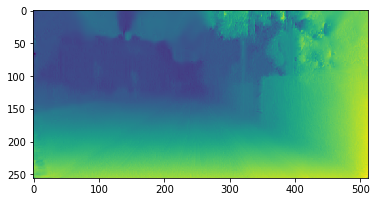

In [41]:
#net = torch.load("/eva_data/hylai_model/cs_lr_crop_model/model_epoch10", map_location={'cuda:2':'cuda:1'})
#net = torch.load("/eva_data/hylai_model/new_lr_grad_model/model_epoch45")
net = torch.load("/eva_data/hylai_model/kitti_flow_unsupervised_sample/model_epoch50", map_location={'cuda:1':'cuda:0'})
disparities = np.zeros((697, 256, 512), dtype=np.float32)
disparities_pp = np.zeros((697, 256, 512), dtype=np.float32)
for batch_idx, (left, right) in enumerate(TestImageLoader, 0):
    print(batch_idx)
    #plt.imshow(np.flip(right.numpy()[0,0,:,:], 1))
    #model_input = Variable(torch.cat((right, left), 1).cuda())
    left_batch = torch.cat((left, torch.from_numpy(np.flip(left.numpy(), 3).copy())), 0)
    right_batch = torch.cat((right, torch.from_numpy(np.flip(right.numpy(), 3).copy())), 0)
    model_input = Variable(torch.cat((left_batch, right_batch), 1).cuda())
    #model_input = Variable(left.cuda())
    disp_est_scale, disp_est = net(model_input)
    disparities[batch_idx] = -disp_est[0][0,0,:,:].data.cpu().numpy()
    #print(disp_est_scale[0][1,0,:,:])
    plt.imshow(-disp_est_scale[0][0,0,:,:].data.cpu().numpy())
    disp_pp = post_process_disparity(disp_est[0][:,0,:,:].data.cpu().numpy())
    disparities_pp[batch_idx] = disp_pp
    #disp_to_img = scipy.misc.imresize(disp_pp, [375, 1242])
    #print(disp_pp)
    #plt.imshow(disp_pp)
    break
#np.save('/home/hylai/monodepth/disparities.npy', disparities)
#np.save('/home/hylai/monodepth/disparities_pp.npy', disparities_pp)

0
-22.0 torch.Size([1, 2, 256, 512])
Variable containing:
-28.4327
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 torch.Size([2, 2, 256, 512])
6.5230339454380895


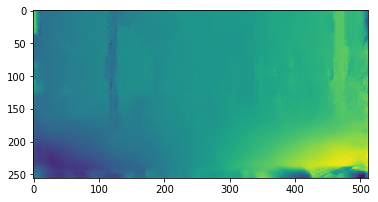

In [280]:
#evaluation on KITTI flow validation set(training 150~199)
net = torch.load("/eva_data/hylai_model/kitti_flow_unsupervised_sample/model_epoch50", map_location={'cuda:1':'cuda:0'})
import numpy.linalg as la
total_error = 0
for batch_idx, (left, right, gt) in enumerate(TestFlowLoader, 0):
    print(batch_idx)
    left_batch = torch.cat((left, torch.from_numpy(np.flip(left.numpy(), 3).copy())), 0)
    right_batch = torch.cat((right, torch.from_numpy(np.flip(right.numpy(), 3).copy())), 0)
    model_input = Variable(torch.cat((left_batch, right_batch), 1).cuda())
    
    disp_est_scale, disp_est = net(model_input)
    a = -disp_est_scale[0][0,:,:,:].data.cpu().numpy()
    b = np.flip(disp_est[0][1,0,:,:].data.cpu().numpy(), 1)
    print(gt.min(), gt.shape)
    print(disp_est_scale[0].min(), disp_est_scale[0].shape)
    plt.imshow(gt[0,0,:,:])
    plt.imshow(disp_est_scale[0][0,0,:,:].data.cpu().numpy())
    error = np.mean(la.norm(disp_est_scale[0][0,:,:,:].data.cpu().numpy() - gt[0], axis=0))
    total_error += error
    break
total_error /= 50
print(total_error)

141 0

    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0    -6    -6  ...     12     2     0
    0     0     0  ...      2     0     0
    0     0     0  ...      0     0     0
[torch.DoubleTensor of size 256x512]



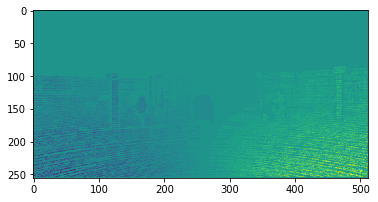

In [257]:
flow = '/eva_data/hylai_model/dataset/kitti/training/flow_occ/000150_10.png'
flow_image = Image.open(flow).convert('RGB')
#print(np.asarray(flow_image).min())
#print(np.asarray(flow_image)[:,:,0])
#plt.imshow(np.asarray(flow_image)[:,:,0])
flow_image = transforms.Scale([512, 256])(flow_image)
flow_image = np.asarray(flow_image)
print(flow_image.max(), flow_image.min())
a = (flow_image[:,:,0] / 256 - 0.5) * flow_image.shape[1]
b = (flow_image[:,:,1] / 256 - 0.5) * flow_image.shape[0]
plt.imshow(a)
a = np.expand_dims(a, 0)
b = np.expand_dims(b, 0)
c = np.concatenate((a,b), 0)
c = torch.from_numpy(c)
print(c[0,:,:])

In [ ]:
1. KITTI flow dataset is too small(200 pairs), CityScapes on request
2. flow loss function, some of pixels are 0, learning rate
3. left-right consistency

In [67]:
#test
import scipy.misc

input_image = scipy.misc.imread("./test.jpg", mode="RGB")
original_height, original_width, num_channels = input_image.shape
input_image = scipy.misc.imresize(input_image, [256, 512], interp='lanczos')
input_image = input_image.astype(np.float32) / 255
input_images = np.stack((input_image, np.fliplr(input_image)), 0)
model_input = Variable(torch.from_numpy(input_images.transpose((0,3,1,2))).cuda())
disp_est = net(model_input)

disp_pp = post_process_disparity(disp_est[0][:,0,:,:].data.cpu().numpy())
disp_to_img = scipy.misc.imresize(disp_pp, [original_height, original_width])
plt.imshow(disp_to_img)
plt.imsave("./myresult.png", disp_to_img, cmap='plasma')
#torch.save(net, "./model_city2kitti")
print(disp_to_img)

/home/hylai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/hylai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


RuntimeError: Given groups=1, weight[64, 6, 7, 7], so expected input[2, 3, 256, 512] to have 6 channels, but got 3 channels instead